The goal of this Notebook is to demonstrate how the selective sampling procedure works.

In [20]:
#Importing code functions other files
from gaussianProcess import *
from importingAndPreprocessingData import *
from postProcessingData import *
from bayesianOptimization import *
from plotData import *

Importing grain boundary data. Only one grain boundary can be studied at a time.

In [21]:
dataFileName = "210GB_Y0.csv"
numberOfIndexes = 80

#Uncomment to rather perform selective sampling on one of these grain boundaries
#dataFileName = "210GB_Y5.csv"
#numberOfIndexes = 80

#dataFileName = "111GB.csv"
#numberOfIndexes = 144

Set which descriptors to use in the sampling procedure.

In [22]:
descriptors = ["xDirect", "bondLengthRatio"]
hyperParams = [0.1, 0.1] #Initial guess of hyper parameters, must be of same length as descriptor list

Set parameters used in the sampling procedure

In [23]:
n_rand = 10 #Number of initial, randomly selected grid points
n_random_seeds = 3 #Number of times to repeat the procedure (with different random seeds) for a given descriptor combination. 
#n_random_seeds was set to 500 and 1000 in Paper II
convergenceDataObj = ConvergenceData()
visualize_first_iterations = True #If true, the first 10 iterations of the first sampling procedure will be visualized

#General input parameters
energyFilter = 10

#Gaussian process parameters
length_scale_bounds = (1e-50, 1e50)
gp_kernel = RBF(hyperParams, length_scale_bounds)
n_restarts_optimizer = 100
gpr_noise_param = 1e-5
gprParams = {"gp_kernel": gp_kernel, "n_restarts_optimizer": n_restarts_optimizer, "gpr_noise_param": gpr_noise_param}

## Selective sampling

Running the selective sampling procedure.

First, the procedure is initialized by selecting $N_\mathrm{rand}$ grid points, and making a Gaussian process prediction based on those grid points.

Then, it iterates until the expected improvement is lower than $10^{-100}$, and collects data as a function of convergence criterion (to check what convergence criterion is sufficient), and store the data in expectedImprovementConvergenceData.csv.

The data in expectedImprovementConvergenceData.csv has three rows for each convergence criterion: the first row shows the number of iterations at convergence; the second row shows the index with the lowest energy, i.e. the index the sampling procedure claims to be the grain boundary structure with the lowest energy; the third index shows the CPU cost at this point. The first column shows the convergence criterion, the subsequent columns shows the convergence results for each sampling procedures (such that the total number of columns is 1 + n_random_seeds).

If visualize_first_iterations is set to True, the first ten iterations of the first sampling procedure is visualized. Note that this visualization does not make much sense for the (111) grain boundary, since that grain boundary has two dimensional spatial descriptors.

Step:  1


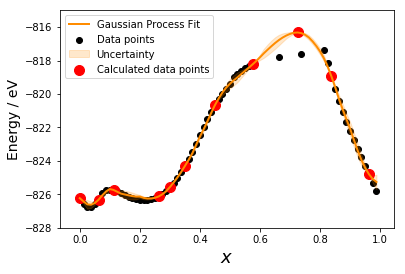

Step:  2


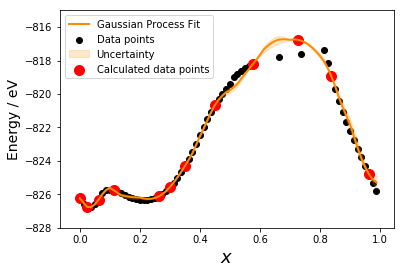

Step:  3


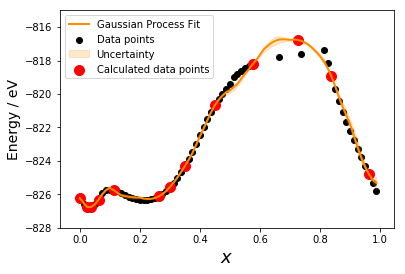

Step:  4


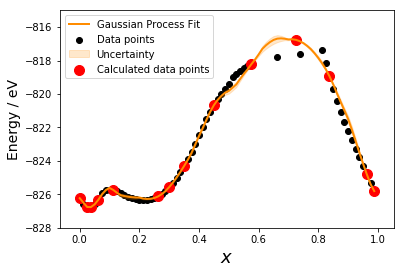

Step:  5


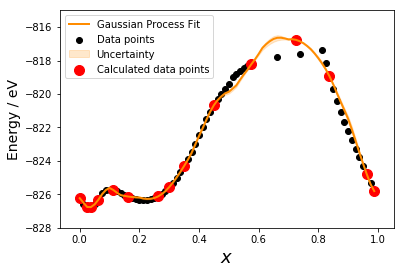

Step:  6


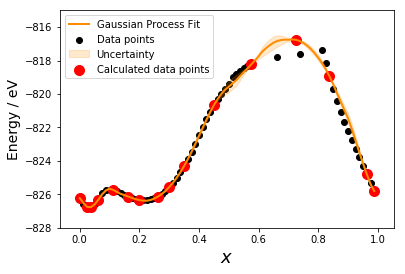

Step:  7


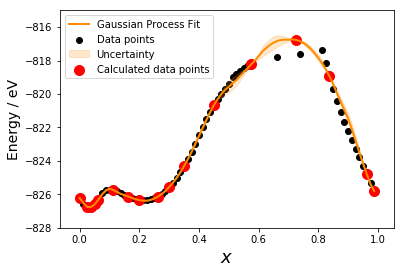

Step:  8


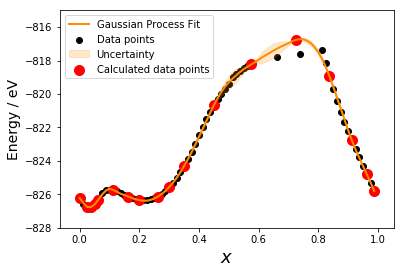

Step:  9


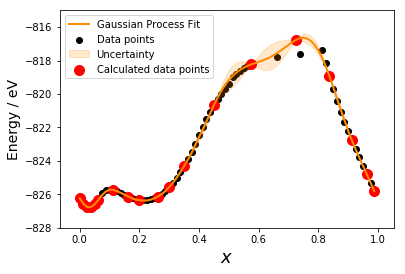

Step:  10


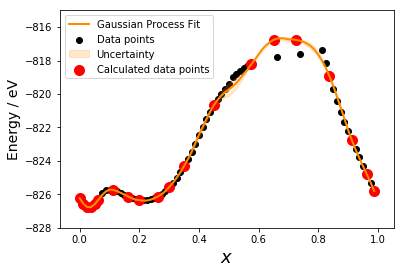

Saved the following file:  expectedImprovementConvergenceData.csv


In [24]:
for i in range(n_random_seeds):

    #Initialize Gaussian process
    indexesToCalculate = np.random.choice(numberOfIndexes, n_rand, replace=False).tolist()
    importedData = ImportAndPreProcessData(dataFileName, descriptors)
    predictedDataObj = PredictData(importedData, gprParams, energyFilter, indexesToCalculate)
    nextIndexCalcObj = GetNextIndexExpectedImprovement(importedData, predictedDataObj, indexesToCalculate)
    gatheredData = GatherDataExpectedImprovement(importedData, predictedDataObj, nextIndexCalcObj)

    #Iterate until convergence
    for j in range(0, numberOfIndexes - (n_rand + 2)):
        if nextIndexCalcObj.expectedImprovement < 1e-100:
            break
        indexesToCalculate.append(nextIndexCalcObj.nextIndex)
        predictedDataObj = PredictData(importedData, gprParams, energyFilter, indexesToCalculate)
        nextIndexCalcObj = GetNextIndexExpectedImprovement(importedData, predictedDataObj, indexesToCalculate, nextIndexCalcObj.thresholdEstimate)
        gatheredData = GatherDataExpectedImprovement(importedData, predictedDataObj, nextIndexCalcObj, gatheredData)
        
        if visualize_first_iterations and (i == 0) and (j < 10):
            print("Step: ", j+1)
            PlotDataExpectedImprovement(importedData, predictedDataObj, nextIndexCalcObj, gatheredData).plot1dEnergyData()
            plt.ylim(-828, -815)
            plt.show()

    #Sort data based on convergence criteria
    convergenceCriterionList = [1e-1, 1e-3, 1e-5, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30, 1e-35, 1e-40, 1e-45, 1e-50, 1e-55, 1e-60, 1e-65, 1e-70, 1e-75, 1e-80, 1e-85, 1e-90, 1e-95, 1e-100]
    singleRunConvergenceData = gatheredData.getSingleRunConvergenceData(convergenceCriterionList)
    convergenceDataObj = ConvergenceData(convergenceDataObj, convergenceCriterionList, singleRunConvergenceData)

#Save convergence data
convergenceDataObj.writeConvergenceDataToCsv()
